# Исследование аудиоданных и базовой обработки
Этот ноутбук предназначен для:
1. Анализа структуры аудиосигналов
2. Изучения типов шумов
3. Прототипирования базовых методов обработки


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
from pathlib import Path
import scipy.signal as signal
import warnings
warnings.filterwarnings('ignore')

# Для отображения графиков в высоком качестве
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## 2. Загрузка и анализ аудиофайлов

In [3]:
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# %%
def load_and_analyze_audio(filepath, sr=22050):
    """Загрузка аудиофайла и его анализ"""
    # Загрузка аудио
    audio, sr = librosa.load(filepath, sr=sr)
    
    # Основные характеристики
    duration = librosa.get_duration(y=audio, sr=sr)
    print(f"Длительность: {duration:.2f} сек")
    print(f"Частота дискретизации: {sr} Гц")
    print(f"Количество отсчетов: {len(audio)}")
    print(f"Диапазон амплитуд: [{audio.min():.3f}, {audio.max():.3f}]")
    
    return audio, sr

In [2]:
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
def load_and_analyze_audio(filepath, sr=22050):
    """Загрузка аудиофайла и его анализ"""
    # Загрузка аудио
    audio, sr = librosa.load(filepath, sr=sr)
    
    # Основные характеристики
    duration = librosa.get_duration(y=audio, sr=sr)
    print(f"Длительность: {duration:.2f} сек")
    print(f"Частота дискретизации: {sr} Гц")
    print(f"Количество отсчетов: {len(audio)}")
    print(f"Диапазон амплитуд: [{audio.min():.3f}, {audio.max():.3f}]")
    
    return audio, sr

## 3. Создание тестовых сигналов

In [5]:
def create_test_signals(sr=22050, duration=5):
    """Создание тестовых сигналов для экспериментов"""
    
    t = np.linspace(0, duration, int(sr * duration))
    
    # Чистый сигнал (тональный + речь-подобный)
    f1, f2 = 440, 880  # Частоты в Гц (Ля первой и второй октавы)
    tone = 0.3 * np.sin(2 * np.pi * f1 * t) + 0.2 * np.sin(2 * np.pi * f2 * t)
    
    # Имитация речи (через частотную модуляцию)
    speech_like = 0.5 * np.sin(2 * np.pi * 200 * t * (1 + 0.1 * np.sin(2 * np.pi * 5 * t)))
    
    # Шумы
    white_noise = 0.1 * np.random.randn(len(t))
    pink_noise = 0.1 * np.cumsum(np.random.randn(len(t))) / np.sqrt(np.arange(1, len(t) + 1))
    harmonic_noise = 0.15 * np.sin(2 * np.pi * 100 * t) + 0.1 * np.sin(2 * np.pi * 1000 * t)
    
    # Смеси
    noisy_tone = tone + white_noise + 0.05 * pink_noise
    noisy_speech = speech_like + 0.2 * white_noise + 0.1 * harmonic_noise
    
    signals = {
        'clean_tone': tone,
        'clean_speech': speech_like,
        'white_noise': white_noise,
        'pink_noise': pink_noise,
        'harmonic_noise': harmonic_noise,
        'noisy_tone': noisy_tone,
        'noisy_speech': noisy_speech,
        'sr': sr,
        't': t
    }
    
    return signals

In [6]:
# Создаем тестовые сигналы
test_signals = create_test_signals()

# Сохраняем для дальнейшего использования
for name, signal_data in test_signals.items():
    if name not in ['sr', 't']:
        sf.write(DATA_DIR / f"{name}.wav", signal_data, test_signals['sr'])


## 4. Визуализация сигналов

In [7]:
def plot_waveforms(signals):
    """Визуализация временных рядов сигналов"""
    fig, axes = plt.subplots(4, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    plot_signals = ['clean_tone', 'clean_speech', 'white_noise', 'pink_noise',
                   'harmonic_noise', 'noisy_tone', 'noisy_speech']
    
    for idx, name in enumerate(plot_signals):
        if idx < len(axes):
            ax = axes[idx]
            signal_data = signals[name]
            t = signals['t'][:len(signal_data)] if len(signal_data) < len(signals['t']) else signals['t']
            
            ax.plot(t[:1000], signal_data[:1000])  # Первые 1000 отсчетов для наглядности
            ax.set_title(f"{name} (первые 1000 отсчетов)")
            ax.set_xlabel("Время (с)")
            ax.set_ylabel("Амплитуда")
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

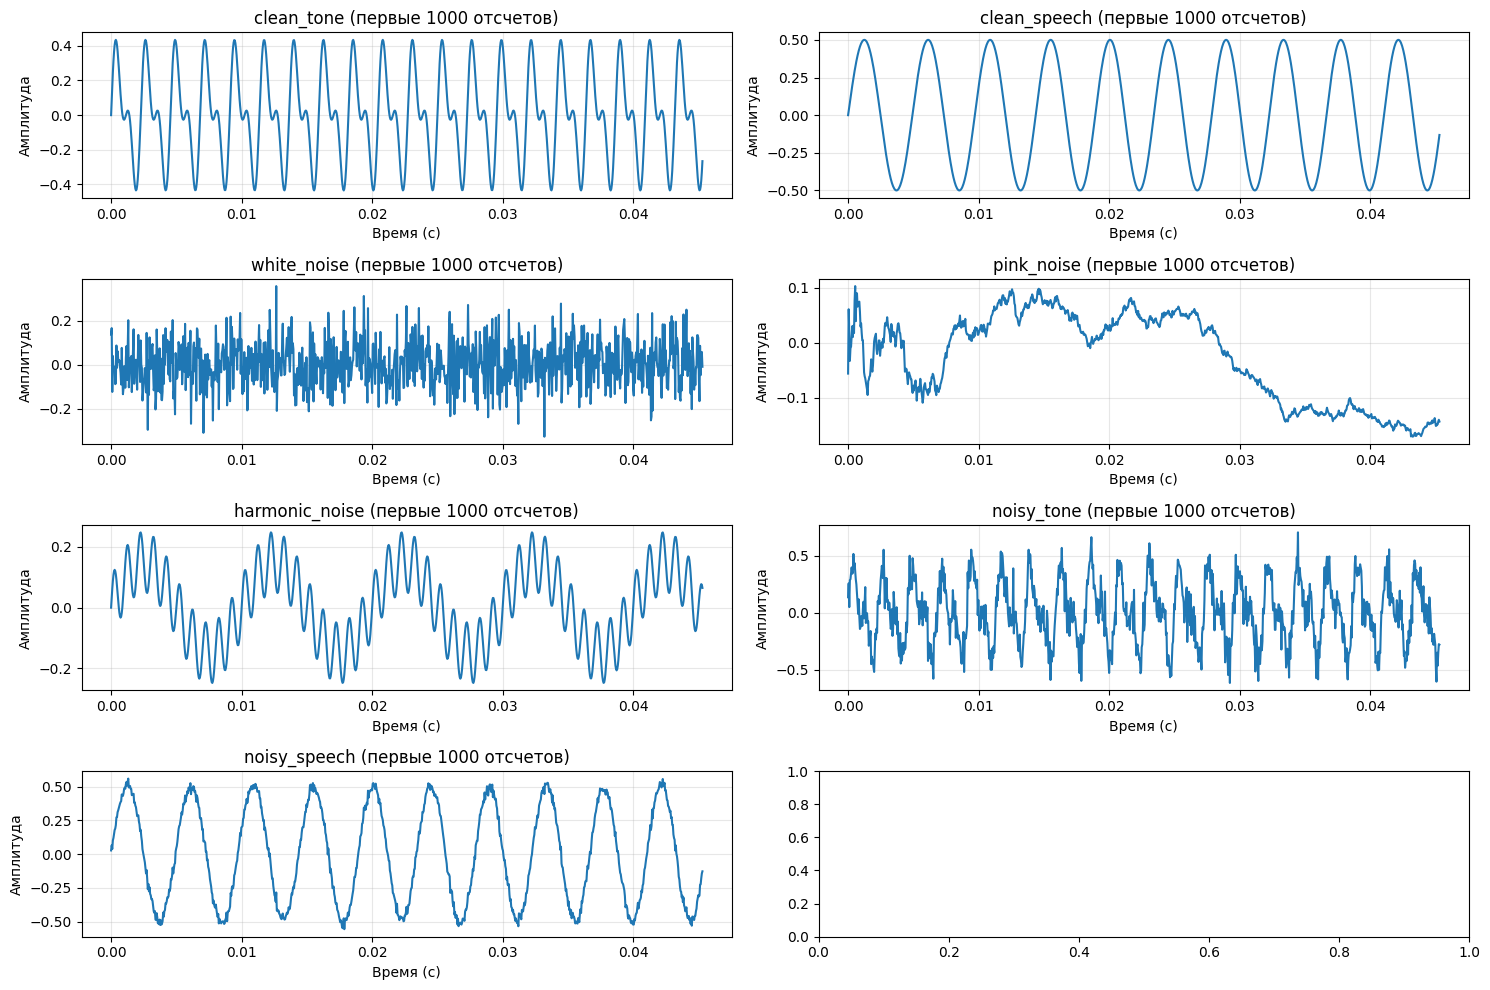

In [8]:
plot_waveforms(test_signals)

## 5. Спектральный анализ

In [9]:
def plot_spectrograms(signals):
    """Визуализация спектрограмм сигналов"""
    fig, axes = plt.subplots(4, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    plot_signals = ['clean_tone', 'clean_speech', 'white_noise', 'pink_noise',
                   'harmonic_noise', 'noisy_tone', 'noisy_speech']
    
    for idx, name in enumerate(plot_signals):
        if idx < len(axes):
            ax = axes[idx]
            signal_data = signals[name]
            sr = signals['sr']
            
            # Вычисляем спектрограмму
            D = librosa.stft(signal_data)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            
            # Рисуем спектрограмму
            img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=ax)
            ax.set_title(f"Спектрограмма: {name}")
            ax.set_xlabel("Время (с)")
            ax.set_ylabel("Частота (Гц)")
            
            if idx == len(plot_signals) - 1:
                fig.colorbar(img, ax=ax, format="%+2.0f dB")
    
    plt.tight_layout()
    plt.show()

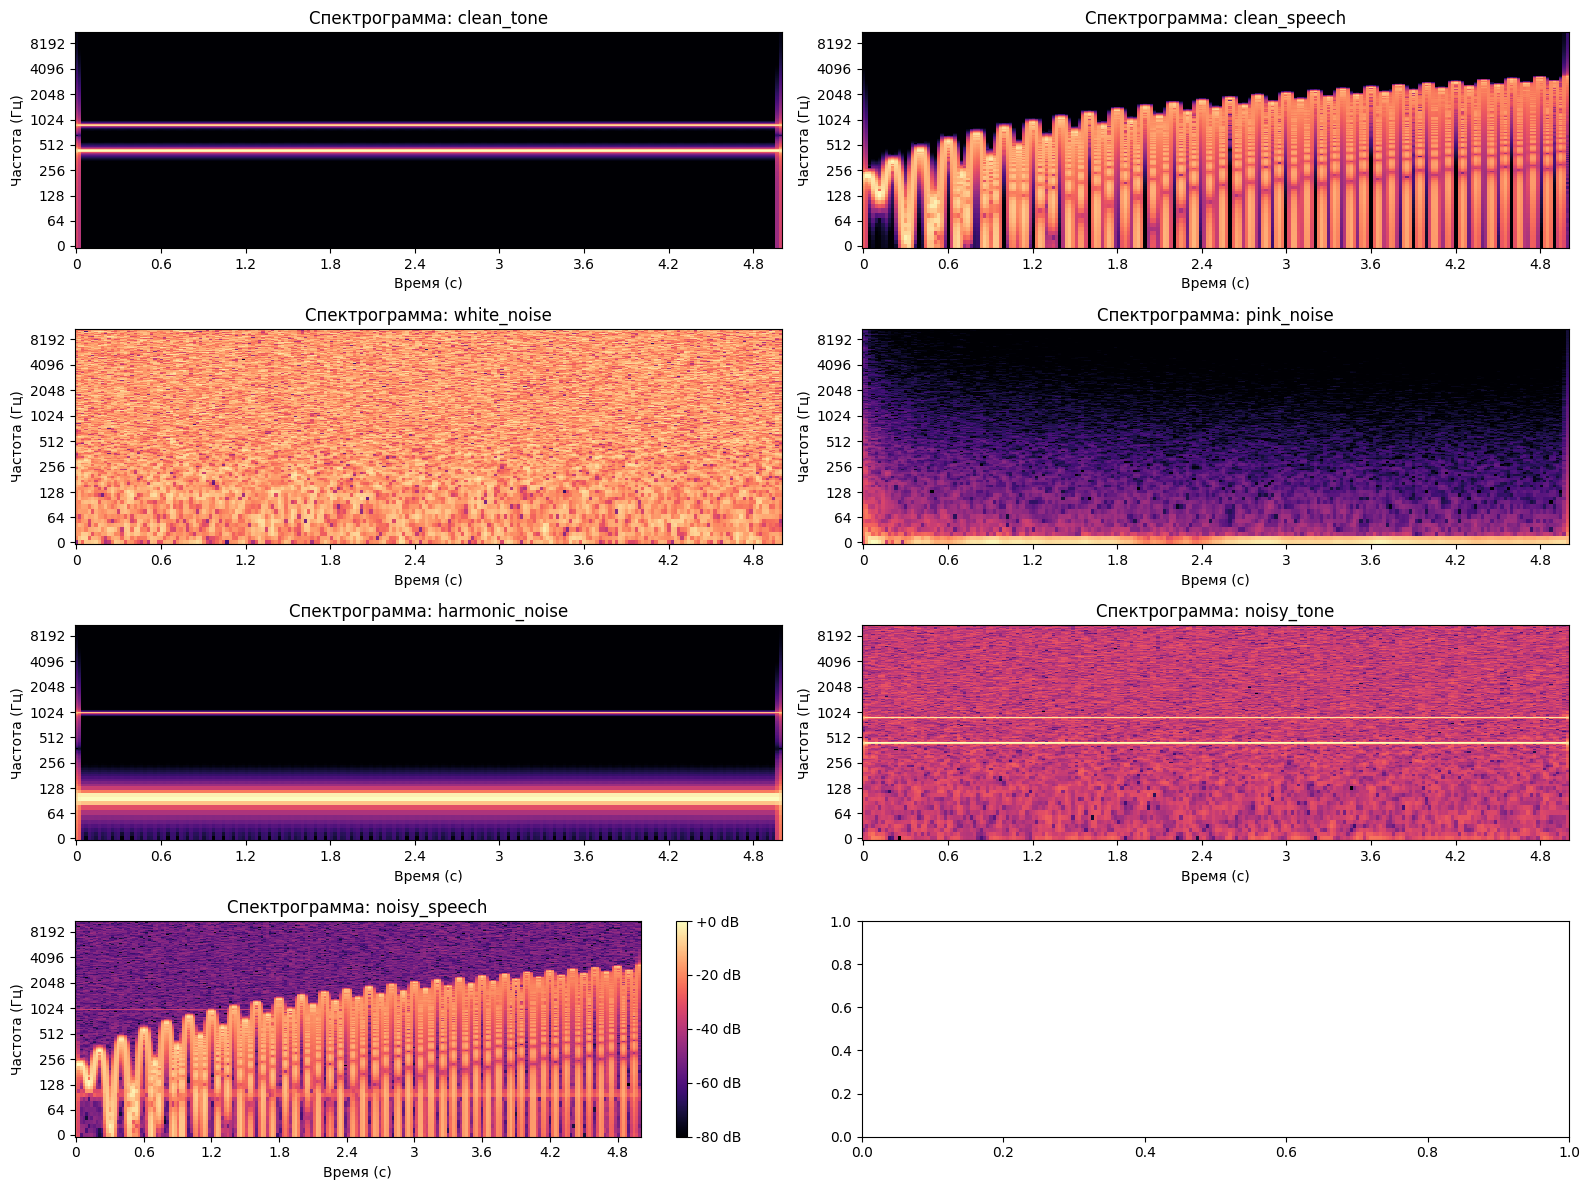

In [10]:
plot_spectrograms(test_signals)

## 6. Статистический анализ

In [11]:
def analyze_statistics(signals):
    """Статистический анализ сигналов"""
    import pandas as pd
    
    stats = []
    for name in ['clean_tone', 'clean_speech', 'white_noise', 'noisy_tone', 'noisy_speech']:
        signal_data = signals[name]
        
        stats.append({
            'Сигнал': name,
            'Среднее': np.mean(signal_data),
            'СКО': np.std(signal_data),
            'Максимум': np.max(np.abs(signal_data)),
            'Энергия': np.sum(signal_data ** 2),
            'Динамический диапазон (дБ)': 20 * np.log10(np.max(np.abs(signal_data)) / (np.std(signal_data) + 1e-10))
        })
    
    df_stats = pd.DataFrame(stats)
    return df_stats

In [12]:
df_stats = analyze_statistics(test_signals)
print("Статистические характеристики сигналов:")
display(df_stats)

Статистические характеристики сигналов:


,Сигнал,Среднее,СКО,Максимум,Энергия,Динамический диапазон (дБ)
0,clean_tone,5.497845e-17,0.254950,0.434311,7166.185000,4.626913
1,clean_speech,-1.263077e-03,0.354220,0.500000,13833.476980,2.993928
2,white_noise,9.656138e-05,0.100300,0.517112,1109.119440,14.245694
3,noisy_tone,3.663064e-03,0.273638,0.917817,8256.727908,10.511608
4,noisy_speech,-1.243765e-03,0.355345,0.581984,13921.414186,4.285223


## 7. Корреляционный анализ

In [13]:
def plot_correlations(signals):
    """Анализ корреляций между сигналами"""
    import seaborn as sns
    
    # Выбираем сигналы для анализа
    signal_names = ['clean_tone', 'clean_speech', 'white_noise', 'harmonic_noise', 'noisy_tone', 'noisy_speech']
    
    # Создаем матрицу корреляций
    corr_matrix = np.zeros((len(signal_names), len(signal_names)))
    
    for i, name_i in enumerate(signal_names):
        for j, name_j in enumerate(signal_names):
            # Обрезаем до минимальной длины
            min_len = min(len(signals[name_i]), len(signals[name_j]))
            corr = np.corrcoef(signals[name_i][:min_len], signals[name_j][:min_len])[0, 1]
            corr_matrix[i, j] = corr
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', 
                xticklabels=signal_names, yticklabels=signal_names,
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Матрица корреляций между сигналами')
    plt.tight_layout()
    plt.show()

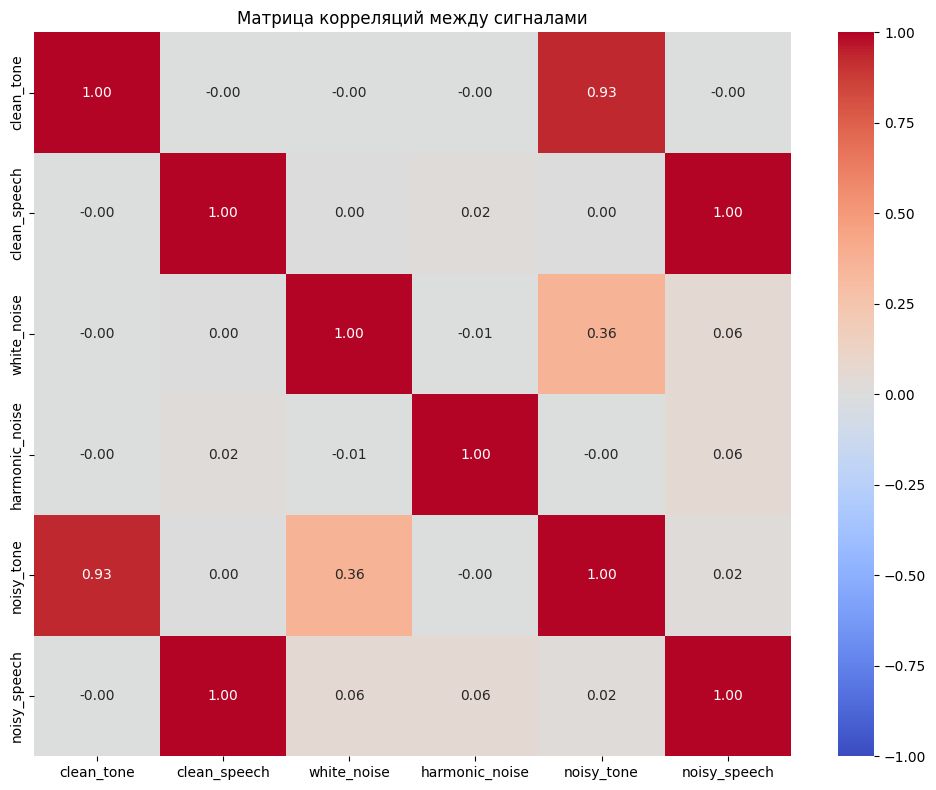

In [14]:
plot_correlations(test_signals)

## 8. Прослушивание сигналов

In [15]:
def listen_to_signals(signals, signal_names):
    """Функция для прослушивания сигналов в ноутбуке"""
    for name in signal_names:
        print(f"\n{name}:")
        ipd.display(ipd.Audio(signals[name], rate=signals['sr']))


In [16]:
# Прослушиваем ключевые сигналы
listen_to_signals(test_signals, ['clean_tone', 'clean_speech', 'noisy_tone', 'noisy_speech'])


clean_tone:



clean_speech:



noisy_tone:



noisy_speech:


## 9. Анализ реальных голосовых записей

In [17]:
def analyze_real_audio(filepath, sr=16000):
    """Анализ реального аудиофайла"""
    if not Path(filepath).exists():
        print(f"Файл {filepath} не найден")
        return None
    
    audio, sr = librosa.load(filepath, sr=sr)
    
    # Временной график
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(audio)) / sr, audio)
    plt.title(f"Временная область: {Path(filepath).name}")
    plt.xlabel("Время (с)")
    plt.ylabel("Амплитуда")
    plt.grid(True, alpha=0.3)
    
    # Спектрограмма
    plt.subplot(2, 1, 2)
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Спектрограмма")
    plt.tight_layout()
    plt.show()
    
    # Гистограмма амплитуд
    plt.figure(figsize=(10, 4))
    plt.hist(audio, bins=100, alpha=0.7, edgecolor='black')
    plt.title("Распределение амплитуд")
    plt.xlabel("Амплитуда")
    plt.ylabel("Частота")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Основные статистики
    print(f"Длительность: {len(audio)/sr:.2f} сек")
    print(f"Максимальная амплитуда: {np.max(np.abs(audio)):.4f}")
    print(f"Средняя энергия: {np.mean(audio**2):.6f}")
    print(f"Соотношение сигнал/шум (приблизительно): {20*np.log10(np.std(audio)/(np.mean(np.abs(audio - np.mean(audio))) + 1e-10)):.2f} дБ")
    
    return audio, sr

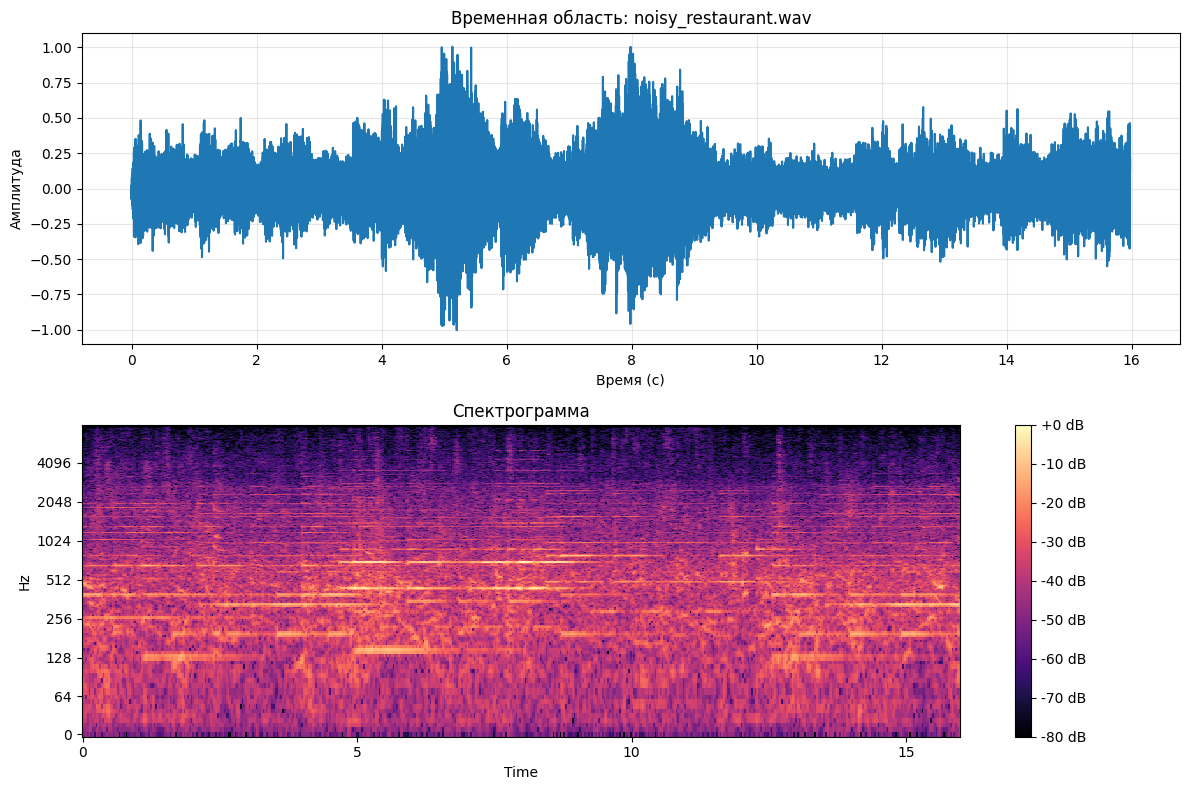

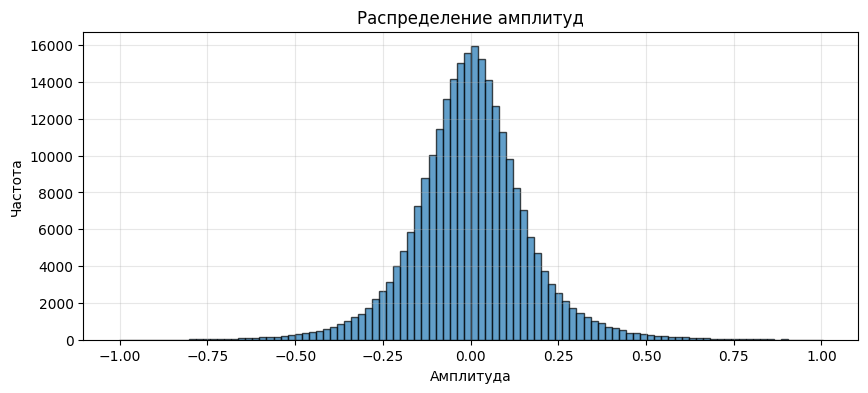

Длительность: 15.97 сек
Максимальная амплитуда: 1.0048
Средняя энергия: 0.027007
Соотношение сигнал/шум (приблизительно): 2.68 дБ


(array([-0.00530555, -0.01352765, -0.02769393, ...,  0.2044785 ,
         0.17972687,  0.12182154], dtype=float32),
 16000)

In [18]:
analyze_real_audio(DATA_DIR / "noisy_restaurant.wav", )

## 10. Сохранение результатов анализа

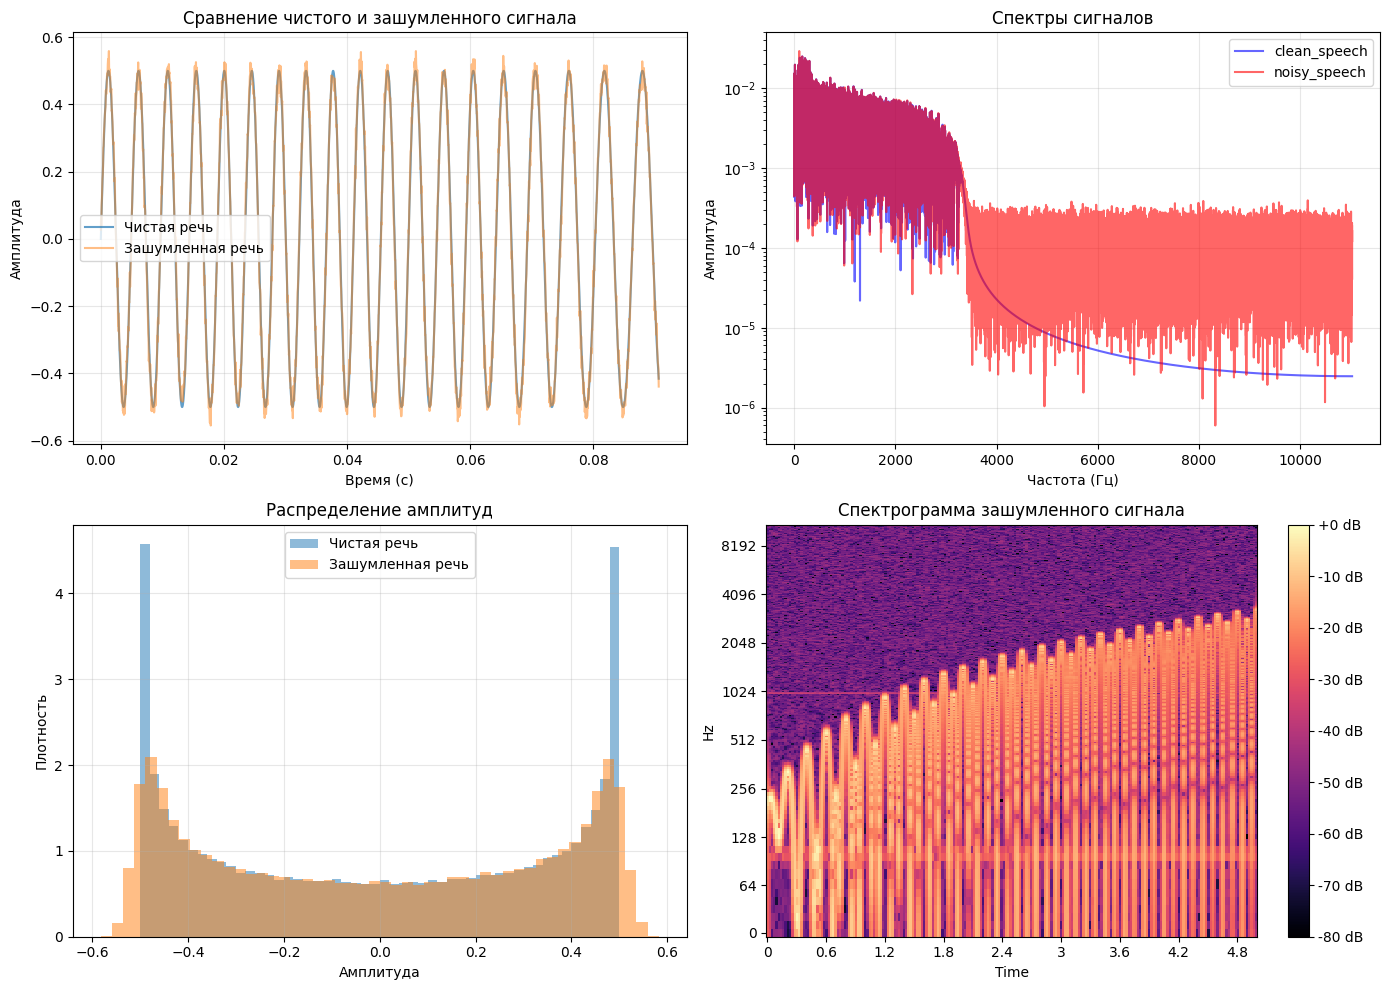


Анализ завершен. Результаты сохранены в ..\data/


In [21]:
# Сохраняем основные графики
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Сравнение чистого и зашумленного сигнала
axes[0, 0].plot(test_signals['t'][:2000], test_signals['clean_speech'][:2000], label='Чистая речь', alpha=0.7)
axes[0, 0].plot(test_signals['t'][:2000], test_signals['noisy_speech'][:2000], label='Зашумленная речь', alpha=0.5)
axes[0, 0].set_title("Сравнение чистого и зашумленного сигнала")
axes[0, 0].set_xlabel("Время (с)")
axes[0, 0].set_ylabel("Амплитуда")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Спектры
from scipy.fft import fft, fftfreq

for name, color in zip(['clean_speech', 'noisy_speech'], ['blue', 'red']):
    signal_data = test_signals[name]
    N = len(signal_data)
    yf = fft(signal_data)
    xf = fftfreq(N, 1/test_signals['sr'])[:N//2]
    axes[0, 1].semilogy(xf, 2.0/N * np.abs(yf[:N//2]), color=color, alpha=0.6, label=name)
axes[0, 1].set_title("Спектры сигналов")
axes[0, 1].set_xlabel("Частота (Гц)")
axes[0, 1].set_ylabel("Амплитуда")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Распределение амплитуд
axes[1, 0].hist(test_signals['clean_speech'], bins=50, alpha=0.5, label='Чистая речь', density=True)
axes[1, 0].hist(test_signals['noisy_speech'], bins=50, alpha=0.5, label='Зашумленная речь', density=True)
axes[1, 0].set_title("Распределение амплитуд")
axes[1, 0].set_xlabel("Амплитуда")
axes[1, 0].set_ylabel("Плотность")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Спектрограмма зашумленного сигнала
ax = axes[1, 1]
D = librosa.stft(test_signals['noisy_speech'])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db, sr=test_signals['sr'], x_axis='time', y_axis='log', ax=ax)
ax.set_title("Спектрограмма зашумленного сигнала")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

plt.tight_layout()
plt.savefig(DATA_DIR / "audio_analysis_summary.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nАнализ завершен. Результаты сохранены в {DATA_DIR}/")

## 11. Экспорт данных для следующего этапа

In [22]:
# Сохраняем обработанные данные в numpy формате
np.savez(DATA_DIR / "processed_signals.npz", 
         clean_speech=test_signals['clean_speech'],
         noisy_speech=test_signals['noisy_speech'],
         sr=test_signals['sr'])

print(f"Данные сохранены в {DATA_DIR}/processed_signals.npz")

Данные сохранены в ..\data/processed_signals.npz
